In [89]:
import pandas as pd

df = pd.read_csv("data/processed/train_ready.csv")
df.sample(2)


,capacitate motor,putere,rulaj,an fabricatie,age_years,marca,brand_category,model_simplified,caroserie,combustibil,...,color_maro_/_bej,color_alta_culoare,color_verde,power_to_displacement,power_per_liter,mileage_per_year,model_frequency,log_mileage,log_engine_size,pret_log
9234,2000,120,227000,2016,8,volvo,premium,UNKNOWN,Hatchback,Diesel,...,0,0,0,60.000,60.000,25222.222222,40,12.332710,7.601402,8.949105
3447,1600,115,247000,2000,24,honda,standard,UNKNOWN,Hatchback,Benzina,...,0,0,0,71.875,71.875,9880.000000,8,12.417148,7.378384,8.006701


In [90]:
import pandas as pd
import numpy as np
import joblib
import os
import json
from datetime import datetime

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# ====================================================
# 1) SET TARGET
# ====================================================

X = df.drop(columns=["pret_log"])
y_log = df["pret_log"]

# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# Identify feature types
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols     = X.select_dtypes(exclude=["object"]).columns.tolist()

# ====================================================
# 2) PREPROCESSING PIPELINE
# ====================================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

rf = RandomForestRegressor(random_state=42)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rf", rf)
])

# ====================================================
# 3) RANDOMIZED SEARCH CONFIG
# ====================================================
param_distributions = {
    "rf__n_estimators": (800,1000),
    "rf__max_depth": (20,None),
    "rf__min_samples_split": (4,6,8),
    "rf__min_samples_leaf": (1,2),
    "rf__max_features":[0.5,0.7],
    "rf__bootstrap": [True]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=40,
    scoring="neg_mean_squared_error",  # on log space
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# ====================================================
# 4) FIT SEARCH
# ====================================================
search.fit(X_train, y_train_log)

print("\nBest parameters found:")
print(search.best_params_)

best_model = search.best_estimator_
best_params = search.best_params_
best_cv_score = search.best_score_  # this is NEGATIVE MSE in log-space

# ====================================================
# 5) METRICS ON TEST SET
# ====================================================
y_pred_log = best_model.predict(X_test)
y_pred     = np.expm1(y_pred_log)
y_true     = np.expm1(y_test_log)

# log-space metrics
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log   = r2_score(y_test_log, y_pred_log)

# price-space metrics
rmse_price = np.sqrt(mean_squared_error(y_true, y_pred))
mae_price  = mean_absolute_error(y_true, y_pred)
r2_price   = r2_score(y_true, y_pred)
mape       = mean_absolute_percentage_error(y_true, y_pred) * 100
accuracy   = 100 - mape

print("\n=== LOG-space Metrics ===")
print(f"RMSE_log: {rmse_log:.4f}")
print(f"R2_log:   {r2_log:.4f}")

print("\n=== PRICE Metrics (EUR) ===")
print(f"RMSE_price: {rmse_price:,.2f} EUR")
print(f"MAE_price:  {mae_price:,.2f} EUR")
print(f"R2_price:   {r2_price:.4f}")
print(f"  MAPE    : {mape:.2f}%")
print(f"  Accuracy: {accuracy:.2f}%")

# ====================================================
# 6) 20 RANDOM SAMPLE PREDICTIONS
# ====================================================
results = pd.DataFrame({
    "true_price": y_true,
    "pred_price": y_pred,
})

results["abs_error"]  = (results["true_price"] - results["pred_price"]).abs()
results["pct_error"]  = results["abs_error"] / results["true_price"] * 100

print("\n=== 20 random predictions (EUR) ===")
print(
    results
    .sample(20, random_state=42)
    .round({"true_price": 0, "pred_price": 0, "abs_error": 0, "pct_error": 2})
)

# ====================================================
# 7) FEATURE IMPORTANCES
# ====================================================
rf_best = best_model.named_steps["rf"]
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()

importances = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_best.feature_importances_,
}).sort_values("importance", ascending=False)

print("\nTop 20 important features:")
print(importances.head(20))

# ====================================================
# 8) SAVE MODEL
# ====================================================
os.makedirs("backend/models_storage/metadata", exist_ok=True)
model_path = "backend/models_storage/random_forest_best.pkl"

joblib.dump(best_model, model_path)
model_size_mb = os.path.getsize(model_path) / 1024 / 1024

print(f"\nModel saved to {model_path} ({model_size_mb:.2f} MB)")

# ====================================================
# 9) SAVE METADATA
# ====================================================

metadata = {
    "saved_at": datetime.now().isoformat(),
    "model_type": "RandomForestRegressor",
    "tuning_method": "RandomizedSearchCV",
    "random_search": {
        "n_iter": 40,
        "cv_folds": 4,
        "scoring": "neg_mean_squared_error (log-space pret_log)",
    },
    "best_parameters": {
        k: (int(v) if isinstance(v, (np.integer,)) else v)
        for k, v in best_params.items()
    },
    "performance_metrics": {
        "rmse_log": float(rmse_log),
        "r2_log": float(r2_log),
        "rmse_price_eur": float(rmse_price),
        "mae_price_eur": float(mae_price),
        "r2_price": float(r2_price),
        "mape_percent": float(mape),
        "accuracy_percent": float(accuracy),
        "cv_best_neg_mse_log": float(best_cv_score),
    },
    "training_info": {
        "train_samples": int(len(X_train)),
        "test_samples": int(len(X_test)),
        "total_features_raw": int(X.shape[1]),
        "total_features_after_encoding": int(len(feature_names)),
        "categorical_features": categorical_cols,
        "numeric_features": numeric_cols,
    },
    "top_features": [
        {
            "rank": i,
            "name": row["feature"],
            "importance": float(row["importance"])
        }
        for i, row in importances.head(20).reset_index(drop=True).iterrows()
    ],
    "paths": {
        "model_path": model_path,
    },
}


metadata_path = "backend/models_storage/metadata/random_forest_best_metadata.json"
with open(metadata_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to {metadata_path}")


Fitting 4 folds for each of 40 candidates, totalling 160 fits

Best parameters found:
{'rf__n_estimators': 1000, 'rf__min_samples_split': 6, 'rf__min_samples_leaf': 1, 'rf__max_features': 0.5, 'rf__max_depth': 20, 'rf__bootstrap': True}

=== LOG-space Metrics ===
RMSE_log: 0.3318
R2_log:   0.7962

=== PRICE Metrics (EUR) ===
RMSE_price: 3,799.60 EUR
MAE_price:  1,791.89 EUR
R2_price:   0.7607
  MAPE    : 23.17%
  Accuracy: 76.83%

=== 20 random predictions (EUR) ===
      true_price  pred_price  abs_error  pct_error
2907      3250.0      2342.0      908.0      27.95
6201     14650.0     13126.0     1524.0      10.41
5927      9290.0     10591.0     1301.0      14.01
8615      6800.0      7093.0      293.0       4.30
8149      7800.0      4941.0     2859.0      36.66
4271      7000.0      8177.0     1177.0      16.82
7711     10900.0     12012.0     1112.0      10.20
7675      7350.0      5778.0     1572.0      21.39
6720      8250.0      6413.0     1837.0      22.26
6223      4499.0   

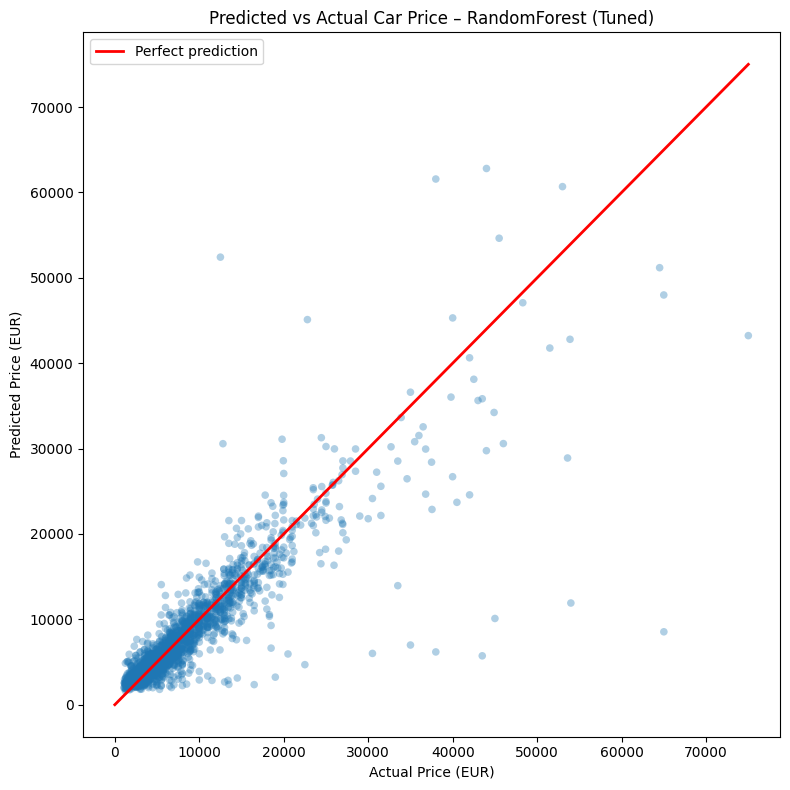

In [91]:
import os
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# RECOMPUTE TRUE & PREDICTED PRICES (EUR)
# =====================================================
y_true = np.expm1(y_test_log)  # actual prices in EUR
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # predicted prices in EUR

# =====================================================
# OUTPUT FOLDER
# =====================================================
os.makedirs("plots", exist_ok=True)

# =====================================================
# PLOT
# =====================================================
plt.figure(figsize=(8, 8))

plt.scatter(
    y_true,
    y_pred,
    alpha=0.35,
    s=30,
    edgecolors="none",
)

# Diagonal reference (perfect predictions)
min_p = 0
max_p = max(y_true.max(), y_pred.max())

plt.plot(
    [min_p, max_p],
    [min_p, max_p],
    color="red",
    linewidth=2,
    label="Perfect prediction",
)

plt.xlabel("Actual Price (EUR)")
plt.ylabel("Predicted Price (EUR)")
plt.title("Predicted vs Actual Car Price – RandomForest (Tuned)")

plt.legend()
plt.tight_layout()

plt.savefig("plots/rf_actual_vs_pred.png", dpi=180)
plt.show()
